In [1]:
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id

dl = DataSet('pbmc',sample_in,sample_out)
dl.config = args
dl.initialize_data()
dl.load_data()
print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/pbmc/pbmc
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/pbmc/pbmc


In [21]:
dl.load_data()
dl.mtx.shape

(7040, 36511)

""
0
ENSG00000243485
ENSG00000237613
ENSG00000186092
ENSG00000238009
ENSG00000239945
...
ENSG00000215635
ENSG00000268590
ENSG00000251180


In [17]:
import anndata
import scanpy as sc

adata = anndata.AnnData(dl.mtx.T)
dfvars = pd.DataFrame(dl.genes)
dfobs = pd.DataFrame(dl.barcodes)
adata.obs = dfobs
adata.var = dfvars

sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=0)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

sc.pp.normalize_total(adata, target_sum=10000)

sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='arpack')


/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


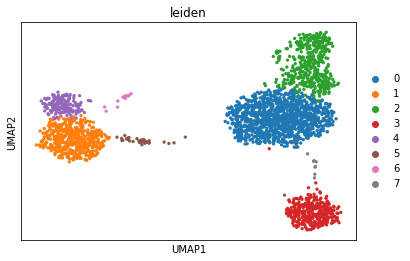

In [18]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])

In [23]:
dfleiden = adata.obs[[0,'leiden']]
dfleiden.to_csv(dl.outpath+'_scanpy.csv.gz',index=False,compression='gzip')

In [24]:
df_rows = pd.read_csv(dl.inpath+'.rows.csv.gz')
df_rows['cell_type']=[x.split('_')[1] for x in df_rows['rows']]
df_rows

,rows,cell_type
0,AAACATACAACCAC-1_3k,3k
1,AAACATTGAGCTAC-1_3k,3k
2,AAACATTGATCAGC-1_3k,3k
3,AAACCGTGCTTCCG-1_3k,3k
4,AAACCGTGTATGCG-1_3k,3k
...,...,...
7035,TTTGGTTTCGCTAGCG-1_4k,4k
7036,TTTGTCACACTTAACG-1_4k,4k
7037,TTTGTCACAGGTCCAC-1_4k,4k
7038,TTTGTCAGTTAAGACA-1_4k,4k


... storing 'celltype' as categorical


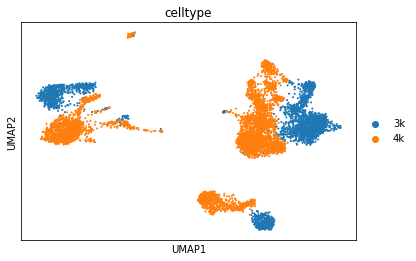

In [25]:
adata.obs['celltype']=df_rows.cell_type.values
sc.pl.umap(adata, color=['celltype'])

In [26]:
adata2 = anndata.AnnData(dl.mtx)
dfvars = pd.DataFrame(dl.cols)
dfobs = pd.DataFrame(dl.rows)
adata2.obs = dfobs
adata2.var = dfvars

In [27]:
sc.pp.normalize_total(adata2, target_sum=10000)

sc.pp.log1p(adata2)

In [28]:
sc.tl.pca(adata2, svd_solver='arpack')

In [29]:
adata2.obs['celltype']=df_rows.cell_type.values

... storing 'celltype' as categorical


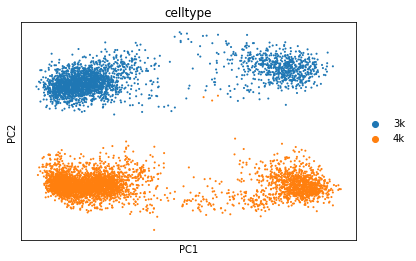

In [30]:
sc.pl.pca(adata2, color='celltype')

In [31]:
adata_combat = anndata.AnnData(dl.mtx)
dfvars = pd.DataFrame(dl.cols)
dfobs = pd.DataFrame(dl.rows)
adata_combat.obs = dfobs
adata_combat.var = dfvars
adata_combat.obs['celltype']=df_rows.cell_type.values

In [32]:
sc.pp.normalize_total(adata_combat, target_sum=10000)

sc.pp.log1p(adata_combat)
sc.pp.combat(adata_combat, key='celltype')

... storing 'celltype' as categorical


Found 15237 genes with zero variance.


/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: invalid value encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


In [33]:
sc.pp.highly_variable_genes(adata_combat)
sc.pp.pca(adata_combat, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_combat)
sc.tl.umap(adata_combat)

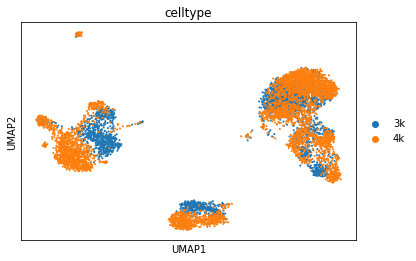

In [34]:
sc.pl.umap(adata_combat, color=['celltype'])

In [3]:
from asap.annotation import ASAPNMF
import asapc 

asap = ASAPNMF(adata=dl)
asap.get_pbulk()
asap.pbulk_mat.shape

(656, 10000)

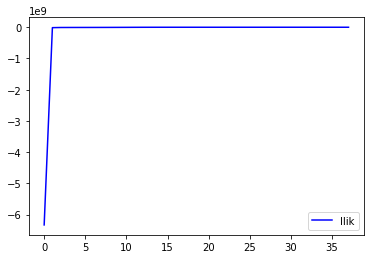

In [4]:
K = 5
nmfm = asapc.ASAPdcNMF(asap.pbulk_mat.T,K)
nmf = nmfm.run()

plt.plot(nmf.llik_trace,'b',label='llik')
plt.legend()

In [5]:
nmf.beta.shape

(10000, 5)

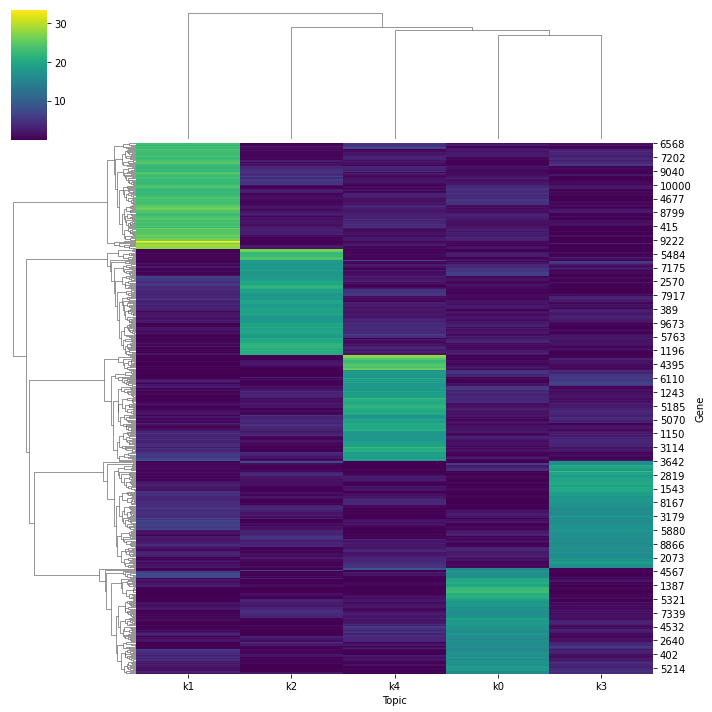

In [6]:
df_beta = pd.DataFrame(nmf.beta.T)

df_beta.columns = dl.cols
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')

# df_top[df_top>100] = 100
sns.clustermap(df_top.T,cmap='viridis')

In [7]:
regm = asapc.ASAPdcNMFPredict(dl.mtx.T,nmf.beta_a,nmf.beta_b)
reg = regm.predict()

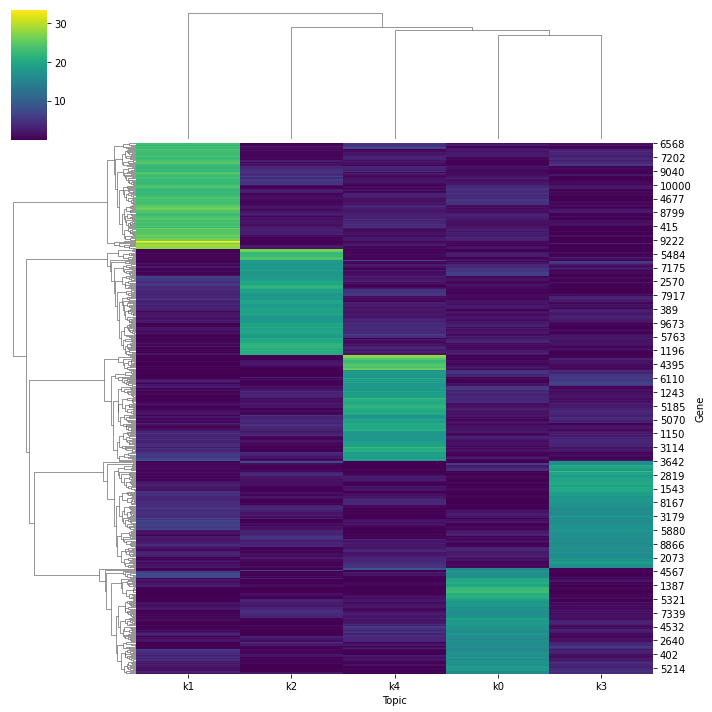

In [8]:
df_beta = pd.DataFrame(reg.beta.T)

df_beta.columns = dl.cols
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')

# df_top[df_top>100] = 100
sns.clustermap(df_top.T,cmap='viridis')

In [9]:
import umap
df_theta = pd.DataFrame(reg.theta)
df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.9,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

,cell,topic_bulk,umap1,umap2
0,1,4,-2.111706,-8.015075
1,2,2,5.427050,-9.955866
2,3,1,14.733659,-0.048954
3,4,3,13.047606,-1.543536
4,5,3,1.380273,4.397564
...,...,...,...,...
2995,2996,3,12.690734,-4.795788
2996,2997,4,-12.011035,10.122079
2997,2998,4,18.792013,9.476200
2998,2999,0,-3.981467,5.017080


Text(0, 0.5, 'UMAP2')

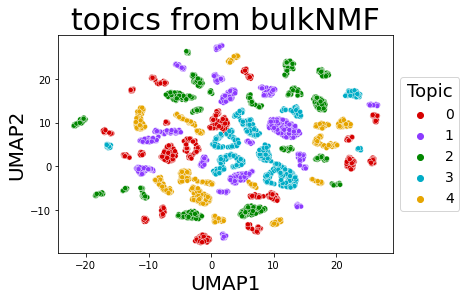

In [10]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=25,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

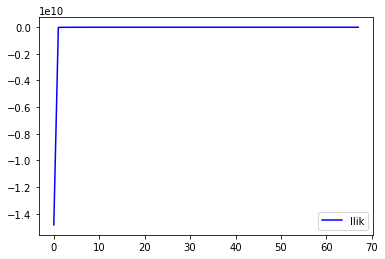

In [11]:
plt.plot(reg.llik_trace,'b',label='llik')
plt.legend()

<AxesSubplot:>

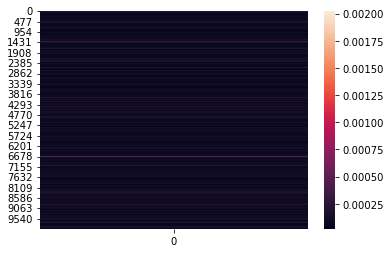

In [18]:
sns.heatmap(reg.row_deg)